<a id="top"></a>
# Compute Items SIFT Features
First:
* [Load Parameters and Items](#load)

Then choose one operation:
* [Compute and Save](#compute)
* [Statistics](#statistics)
* [Plot Item Files](#plot)
* [Computing Test](#test)

## Load Parameters and Items<a id="load"></a>

In [5]:
import json
from utils import load_items

with open('parameters.json', 'r') as infile:
    params = json.load(infile)

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

items = load_items(ITEM_FOLDER)

## Compute and Save<a id="compute"></a>

Issues:
* too many features (e.g. composition_book)
* too few features (e.g. avery_binder)

In [10]:
import cv2, glob
from utils import compute_sift, imread_rgb, imread_gray, pack_keypoint, write_features_to_file

def worker(item):
    folder = ITEM_FOLDER + '/' + item + '/'
    files = glob.glob(folder + '*.png')
    for filename in files:
        image_RGB = imread_rgb(filename)
        if not image_RGB is None:
            image_RGB = cv2.resize(image_RGB,(RESIZE_X,RESIZE_Y))
            file_mask = filename[:-4] + '_mask.pgm'
            mask = imread_gray(file_mask)
            (kp, des) = compute_sift(image_RGB, mask)
            kp, des = pack_keypoint(kp, des) 
            write_features_to_file(filename[:-4] + '_sift.npy', kp, des)

In [11]:
%%time
from multiprocessing import Pool

print('Computing SIFTs of images resized to %d x %d' % (RESIZE_X,RESIZE_Y))
pool_size = 6
pool = Pool(pool_size)
result = []
for item in items:
    result.append( pool.apply_async(worker, (item,)) )
pool.close()
pool.join()
for r in result:
     r.get()

Computing SIFTs of images resized to 600 x 600
CPU times: user 16.2 ms, sys: 36.4 ms, total: 52.6 ms
Wall time: 13.4 s


## Statistics<a id="statistics"></a>

In [12]:
import glob
from utils import read_features_from_file, unpack_keypoint

item_view = []
num_sift = []
for item in items:
    folder = ITEM_FOLDER + '/' + item + '/'
    files = glob.glob(folder + '*_sift.npy')
    for filename in files:
        kp, des = read_features_from_file(filename)
        kp, des = unpack_keypoint(kp, des)
        item_view.append(filename)
        num_sift.append(len(des))

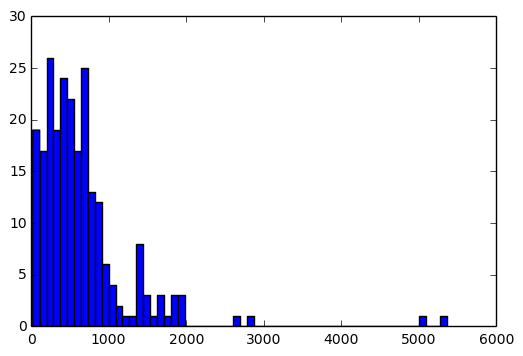

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(num_sift,bins=60);

In [14]:
[(ns, str(iv.split('/')[-1][:-9])) for ns, iv in sorted(zip(num_sift,item_view), reverse=True) if ns>2000]

[(5360, 'composition_book_bottom_01'),
 (5081, 'composition_book_top_01'),
 (2859, 'marbles_bottom_01'),
 (2649, 'pie_plates_top_01')]

In [15]:
[(ns, str(iv.split('/')[-1][:-9])) for ns, iv in sorted(zip(num_sift,item_view), reverse=True) if ns<50]

[(46, 'fiskars_scissors_top_01'),
 (42, 'avery_binder_top-side_02'),
 (39, 'white_facecloth_top-side_01'),
 (37, 'white_facecloth_top_01'),
 (37, 'white_facecloth_top-side_02'),
 (36, 'white_facecloth_bottom-side_01'),
 (31, 'avery_binder_top_01'),
 (29, 'avery_binder_bottom-side_01'),
 (22, 'avery_binder_bottom_01'),
 (20, 'avery_binder_top-side_01'),
 (19, 'avery_binder_bottom-side_02')]

## Plot File<a id="plot"></a>

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
import cv2
from ipywidgets import interact
from utils import imread_rgb, read_features_from_file, unpack_keypoint

def load_and_plot(item,view):
    try:
        prefix = ITEM_FOLDER + '/' + item + '/' + item + '_' + view
        filename = prefix + '_sift.npy'
        kp, des = read_features_from_file(filename)
        kp, des = unpack_keypoint(kp, des)
        filename = prefix + '.png'
        image_RGB = imread_rgb(filename)
        image_RGB = cv2.resize(image_RGB,(RESIZE_X,RESIZE_Y))
        kp_img = cv2.drawKeypoints(image_RGB,kp,color=(0,255,0))
        print('%d features detected' % len(kp))
        plt.imshow(kp_img); plt.axis('off');
    except (IOError, OSError):
        print('File not found')

337 features detected


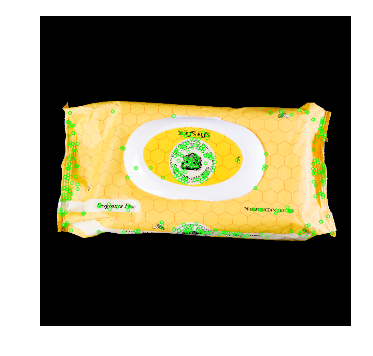

In [25]:
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
interact(load_and_plot,item=items,view=views);

### Plot All Items

In [ ]:
for item in items:
    for view in views:
        print(item + '_' + view)
        load_and_plot(item,view)
        plt.show()

## Computing Test<a id="test"></a>

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
import cv2, numpy as np
from ipywidgets import interact
from utils import compute_sift, imread_rgb, imread_gray

def compute_and_plot(item,view):
    prefix = ITEM_FOLDER + '/' + item + '/' + item + '_' + view
    filename = prefix + '.png'
    image_RGB = imread_rgb(filename)
    if not image_RGB is None:
        image_RGB = cv2.resize(image_RGB,(RESIZE_X,RESIZE_Y))
        filename = prefix + '_mask.pgm'
        mask = imread_gray(filename)
        (kp, des) = compute_sift(image_RGB, mask)
        kp_img = cv2.drawKeypoints(image_RGB,kp,color=(0,255,0))
        print('%d features detected' % len(kp))
        plt.imshow(kp_img); plt.axis('off');

591 features detected


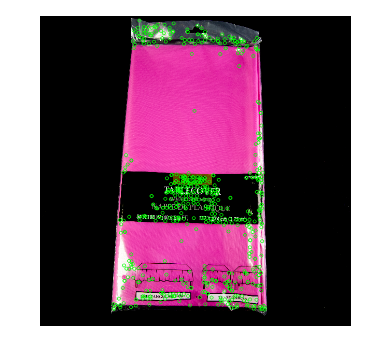

In [29]:
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
interact(compute_and_plot,item=items,view=views);

### Compute and Plot All Items

In [ ]:
for item in items:
    for view in views:
        print(item + '_' + view)
        plot(item,view)
        plt.show()

[Top](#top)